# The impact of slope resampling method

The slope data set has a resolution of 3 arcseconds which is higher than the resolution of 10 arcseconds I want to use in this analysis. Slope therefore has to be downsampled and the question is how. One approach would be bilinear interpolation, but that is clearly optimstic has steeper slopes might be flattened. Another approach is taking the maximum slope. In here I am assessing the impact this has on a simple derivation of land necessary to supply the electricity demand in NUTS3 regions. The "max" resampling approach yields more conservative results with land demand rising in average by 30%.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## Method

The data used in here stems from assessing the land being available for renewable power and then comparing the maximum energy yield on this land to the electricity demand. This leads to the *fraction_land_necessary* which we will compare in the following.

The impact of slope on fraction land necessary can be explained as follows: when the slope rises, the land available for energy provision and with it the electricity yield on that land shrinks. As the electricity demand remains constant, the fraction of land necessary of the one available rises.

The data has been generated by running the full analysis in commit `99e24d6e04df9dd4622dd2dd3e6452802de02e22`. It has been run once with the _bilinear_ approach in the commit, and once with the _max_ approach.

In [2]:
data = pd.read_csv("slope-resampling-method.csv", index_col=0)

In [3]:
data.head()

,COUNTRY_CODE,NUTS_ID,fraction_land_necessary,resampling
0,AT,AT111,0.008022,max
1,AT,AT112,0.009304,max
2,AT,AT211,0.051838,max
3,AT,AT212,0.044785,max
4,AT,AT213,0.020168,max


## Results for selected countries

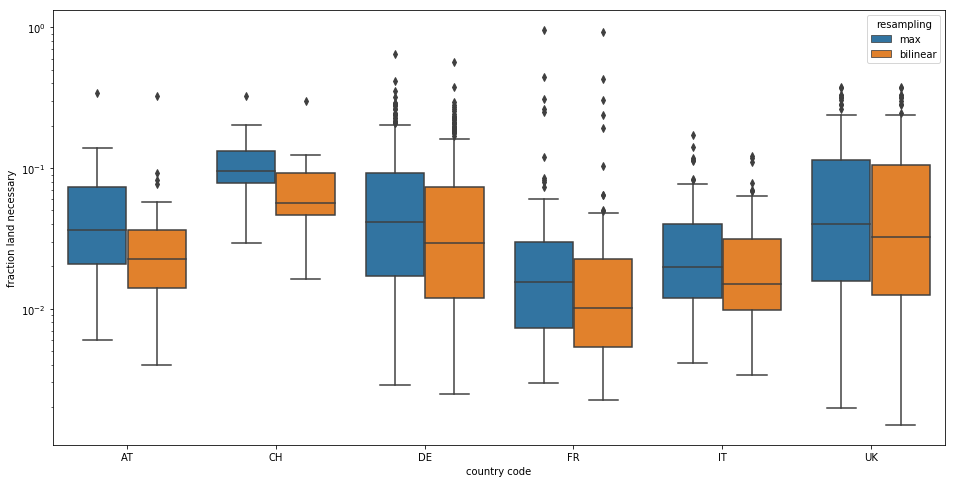

In [4]:
countries = ["AT", "CH", "DE", "FR", "UK", "IT"]
filtered_data = data[data["COUNTRY_CODE"].isin(countries)]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
sns.boxplot(
    data=filtered_data, 
    x="COUNTRY_CODE",
    y="fraction_land_necessary",
    hue="resampling",
    ax=ax
)
_ = plt.ylabel("fraction land necessary")
_ = plt.xlabel("country code")
ax.set_yscale('log')

As can be seen from the figure, the difference for the two approaches varies strongly between different countries. Not very surprisingly, the difference is high for alpine countries like Switzerland and Austria, and relatively smaller for the UK or Germany.

## Statistics of the difference

In [5]:
pivoted_data = data.pivot(columns="resampling", values="fraction_land_necessary", index="NUTS_ID")
pivoted_data.head()

resampling,bilinear,max
NUTS_ID,,
AT111,0.005577,0.008022
AT112,0.008440,0.009304
AT113,0.010438,0.014125
AT121,0.015712,0.027546
AT122,0.032629,0.041654


In [6]:
relative_difference = (pivoted_data["max"] - pivoted_data["bilinear"]) / pivoted_data["bilinear"]

In [7]:
relative_difference.describe([0.25, 0.983])

count    1380.000000
mean        0.306390
std         0.263720
min         0.000000
25%         0.083020
50%         0.249783
98.3%       1.004163
max         1.289093
dtype: float64

The average relative increase in land demand in NUTS3 regions is about 30%. For half of the NUTS3 regions the land demand increases by more than 25%. For more than 1.7% of the regions, the land demand doubles.

In [8]:
absolute_difference = (pivoted_data["max"] - pivoted_data["bilinear"])

In [9]:
absolute_difference.describe([0.25, 0.75])

count    1380.000000
mean        0.008169
std         0.012844
min         0.000000
25%         0.000934
50%         0.003484
75%         0.009509
max         0.165275
dtype: float64

In [10]:
absolute_difference.describe([0.25, 0.98])

count    1380.000000
mean        0.008169
std         0.012844
min         0.000000
25%         0.000934
50%         0.003484
98%         0.046328
max         0.165275
dtype: float64

The average absolute increase in land demand in NUTS3 regions is below 1 percentage point. Only 25% of the NUTS3 regions see an absolute increase that is higher than that. Only 2% of the regions see an increase of more than 5 percentage points. Still, the highest increase is 16 percentage points.

## Discussion

The method used to downsample the slope data from 3 arcseconds to 10 arcseconds has a significant impact on the land available for electricity provision. In average, the land demand as fraction of available land rises by 30% when using a _max_ approach instead of a _bilinear interpolation_ approach. That relative increase corresponds to an absolute increase of less than 1 percentage points and is hence low. 2% of the NUTS3 regions are impacted significantly though, with increases in fraction of land necessary of more than 5 percentage points and up to 16 percentage points. While the bilinear approach is optimistic, the max approach is conservative and yields pessimistic results.

To avoid the resampling, one could instead increase the resolution of the analysis to avoid the downsampling of the slope data. This will come at the cost of longer computation times. This is especially important as the greatest common divisor of the resolutions of the two datasets, 3 and 10, is 1. So to avoid downsampling of the slope data and difficult upsampling of the land cover data, the analysis would need to be performed with a spatial resolution of 1 arcsecond. This is computationally intense.